In [6]:
# mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd drive/

[Errno 2] No such file or directory: 'drive/'
/content/drive/MyDrive/12746-Project/CamVid


In [3]:
cd MyDrive/

/content/drive/MyDrive


In [4]:
cd 12746-Project/

/content/drive/MyDrive/12746-Project


In [5]:
cd CamVid

/content/drive/MyDrive/12746-Project/CamVid


In [8]:
# Common
import os 
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm 
import tensorflow as tf


# Data 
import tensorflow.image as tfi
from tensorflow.keras.utils import Sequence
#from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
# Data Viz

import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import concatenate as c_
from keras.layers import ReLU



In [9]:
def load_data(directory_im,directory_mask,size_h,size_w):
  #This will get the list of names of the images in the directory
  list_names_im=os.listdir(directory_im)
  list_names_mk=os.listdir(directory_mask)
  #The list is stored to make sure image correspond to the mask
  list_names_im.sort()
  list_names_mk.sort()
  #array to store the pixel values
  array_images=[]
  array_masks=[]
  for i in tqdm(range(len(list_names_im))):
  
    # Load images and resize
    img = image.load_img(directory_im+list_names_im[i])
    img = image.img_to_array(img)
    img = tfi.resize(img, (size_h, size_w))/255
    # Load masks and resize the image
    mask = image.img_to_array(image.load_img(directory_mask+list_names_mk[i]))
    mask = tfi.resize(mask, (size_h, size_w))/255
    # add the image array and mask array to the list
    array_images.append(img)
    array_masks.append(mask)
  return array_images,array_masks


In [10]:
train_image_names,train_mask_names=load_data('train/','train_labels/',256,256)
val_image_names,val_mask_names=load_data('val/','val_labels/',256,256)
test_image_names,test_mask_names=load_data('test/','test_labels/',256,256)

100%|██████████| 232/232 [03:11<00:00,  1.21it/s]


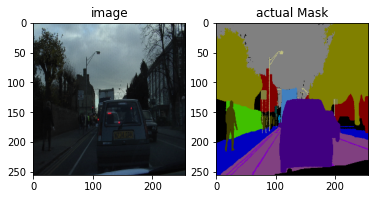

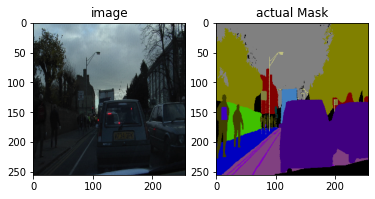

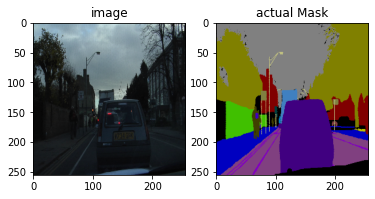

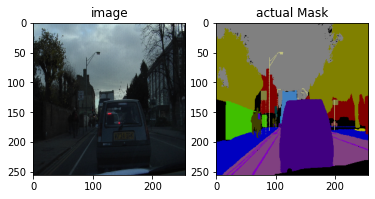

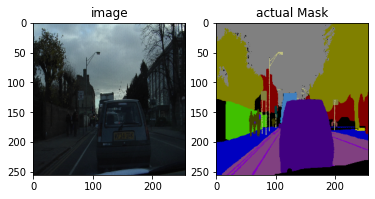

In [ ]:
img=train_image_names[0:5]
label=train_mask_names[0:5]
for i in range(len(img)):
  
  plt.subplot(1,2,1)
  
  plt.imshow(img[i])
  plt.title('image')
  plt.subplot(1,2,2)
  plt.imshow(label[i])
  plt.title('actual Mask')
  plt.show()

In [ ]:
df=pd.read_csv("class_dict.csv")
id_label={}
id_code={}
for i in range(len(df)):
  #print(df.loc[i,:])
  #print(df.loc[i,:]['name'])
  #print((df.loc[i,:]['r'],df.loc[i,:]['b'],df.loc[i,:]['g']))
  id_label[i]=df.loc[i,:]['name']
  id_code[i]=(df.loc[i,:]['r'],df.loc[i,:]['g'],df.loc[i,:]['b'])

print(len(df))

32


In [ ]:
def encoder_unit(input_layer,filter_size,num_filter,dropout=0.1):
  #convolution unit
  conv1 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(input_layer)
  batch1 = tf.keras.layers.BatchNormalization()(conv1)
  relu1 =tf.keras.layers.Activation('relu')(batch1)
  #convolution unit
  conv2 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same') (relu1)
  batch2 = tf.keras.layers.BatchNormalization()(conv2)
  relu2 =tf.keras.layers.Activation('relu')(batch2)
  #max-pooling
  pool1 = tf.keras.layers.MaxPooling2D((2, 2))(relu2)
  drop1 = tf.keras.layers.Dropout(dropout)(pool1) 
  return drop1,relu2

In [ ]:
def decoder_unit(input_layer,concat_layer,filter_size,num_filter,dropout=0.1):
  #transpose convolution 
  deconv1 = tf.keras.layers.Conv2DTranspose(filter_size * num_filter, (3, 3), strides=(2, 2), padding="same")(input_layer)
  #concatenation of output of convolution unit in the encoder
  uconv1 = tf.keras.layers.concatenate([deconv1, concat_layer])
  #dropout layer
  drop1 = tf.keras.layers.Dropout(dropout)(uconv1)
  #convolutional unit
  conv1 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(drop1)
  batch1 = tf.keras.layers.BatchNormalization()(conv1)
  relu1 =tf.keras.layers.Activation('relu')(batch1)
  #convolutional unit
  conv2 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same') (relu1)
  batch2 = tf.keras.layers.BatchNormalization()(conv2)
  relu2 =tf.keras.layers.Activation('relu')(batch2)
  return relu2

In [ ]:
def UNet_model(input_image,dropout=0.1):
  ##Encoder architecture
  fif=16
  output_layer1,conv_output1=encoder_unit(input_image,fif,1,dropout)
  output_layer2,conv_output2=encoder_unit(output_layer1,fif,2,dropout)
  output_layer3,conv_output3=encoder_unit(output_layer2,fif,4,dropout)
  output_layer4,conv_output4=encoder_unit(output_layer3,fif,8,dropout)
  #Middle Convolution
  convm1 = tf.keras.layers.Conv2D(fif * 16, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(output_layer4)
  batchm1 = tf.keras.layers.BatchNormalization()(convm1)
  relum1 =tf.keras.layers.Activation('relu')(batchm1)
  convm2 = tf.keras.layers.Conv2D(fif * 16, (3, 3), kernel_initializer = 'he_normal', padding = 'same') (relum1)
  batchm2 = tf.keras.layers.BatchNormalization()(convm2)
  relum2 =tf.keras.layers.Activation('relu')(batchm2)
  #decorder Architecture
  decode_layer4=decoder_unit(relum2,conv_output4,fif,8,dropout)
  decode_layer3=decoder_unit(decode_layer4,conv_output3,fif,4,dropout)
  decode_layer2=decoder_unit(decode_layer3,conv_output2,fif,2,dropout)
  decode_layer1=decoder_unit(decode_layer2,conv_output1,fif,1,dropout)
  #Output Convolution
  output = Conv2D(3, (1, 1), activation='sigmoid') (decode_layer1)
  model = Model(inputs=[input_image], outputs=[output])
  return model


In [ ]:

input_img = tf.keras.layers.Input(shape=(256, 256, 3))
transformer_model = UNet_model(input_img, 0.05)
transformer_model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=["accuracy",keras.metrics.MeanIoU(num_classes=32, name="IoU")])

In [ ]:
transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
results = transformer_model.fit(np.array(train_image_names), np.array(train_mask_names), epochs=100,batch_size=10,validation_data=(np.array(val_image_names), np.array(val_mask_names)))

Epoch 1/100
37/37 [==============================] - 8s 228ms/step - loss: 0.6543 - accuracy: 0.2327 - IoU: 1.0000 - val_loss: 53.1171 - val_accuracy: 0.7446 - val_IoU: 0.3023
Epoch 2/100
37/37 [==============================] - 6s 150ms/step - loss: 0.5866 - accuracy: 0.4450 - IoU: 1.0000 - val_loss: 2.5722 - val_accuracy: 0.4805 - val_IoU: 0.4914
Epoch 3/100
37/37 [==============================] - 5s 144ms/step - loss: 0.5681 - accuracy: 0.4673 - IoU: 1.0000 - val_loss: 0.6684 - val_accuracy: 0.4618 - val_IoU: 1.0000
Epoch 4/100
37/37 [==============================] - 5s 144ms/step - loss: 0.5615 - accuracy: 0.4840 - IoU: 1.0000 - val_loss: 0.6401 - val_accuracy: 0.4438 - val_IoU: 1.0000
Epoch 5/100
37/37 [==============================] - 5s 144ms/step - loss: 0.5553 - accuracy: 0.5167 - IoU: 1.0000 - val_loss: 0.6502 - val_accuracy: 0.2191 - val_IoU: 1.0000
Epoch 6/100
37/37 [==============================] - 6s 151ms/step - loss: 0.5465 - accuracy: 0.5541 - IoU: 1.0000 - val_los

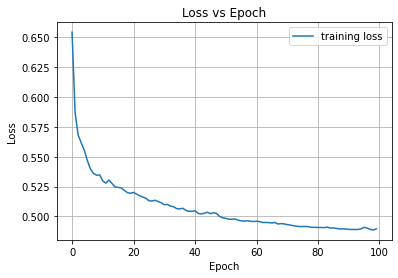

In [ ]:
plt.plot(results.history['loss'], label = 'training loss')
#plt.plot(results.history['val_loss'], label = 'validation loss')
plt.title("Loss vs Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

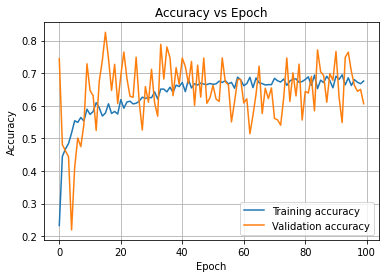

In [ ]:
plt.plot(results.history['accuracy'], label = 'Training accuracy')
plt.plot(results.history['val_accuracy'], label = 'Validation accuracy')
plt.title("Accuracy vs Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
def plot_result(img, predMask, groundTruth):
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [ ]:

def prediction(img,mask, model, shape = 256):
    ## getting and proccessing val data
    mask = mask[:5]   
    imgProc = img[:5]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


4/4 [==============================] - 3s 272ms/step


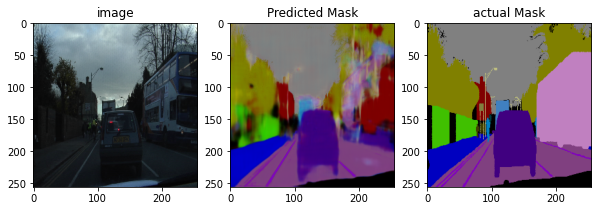

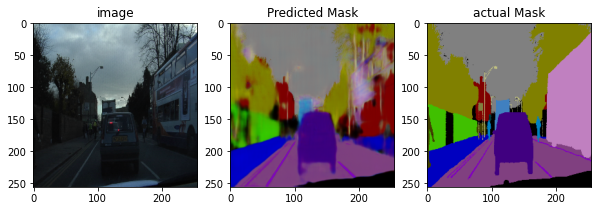

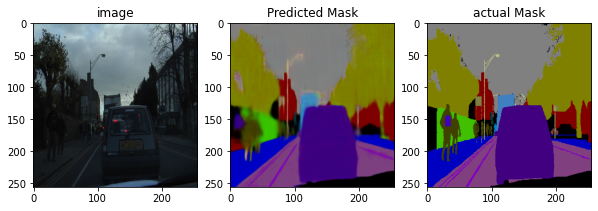

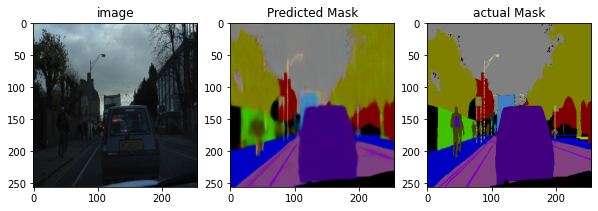

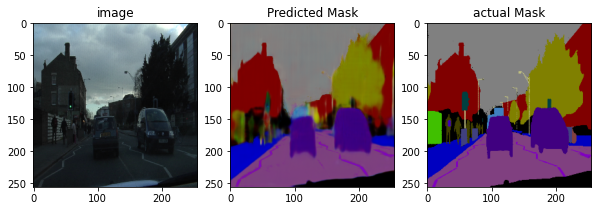

In [ ]:
import cv2 
val_predict, val_img, val_mask = prediction(np.array(val_image_names), np.array(val_mask_names), transformer_model)
for i in range(5):
  plot_result(val_img[i], val_predict[i], val_mask[i])

5/5 [==============================] - 0s 115ms/step


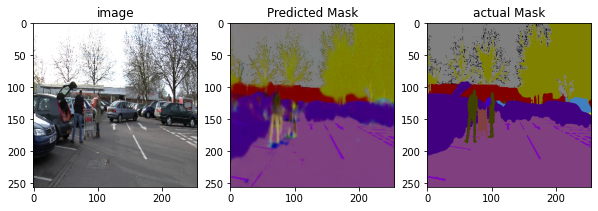

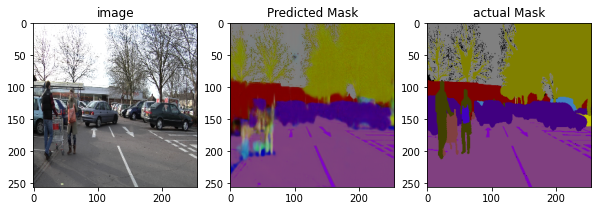

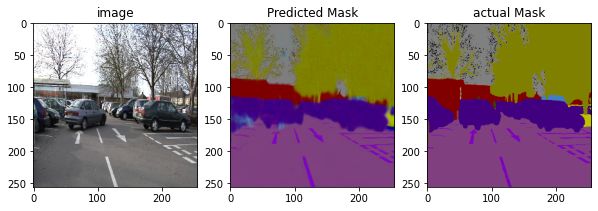

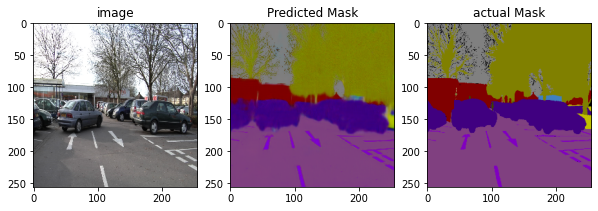

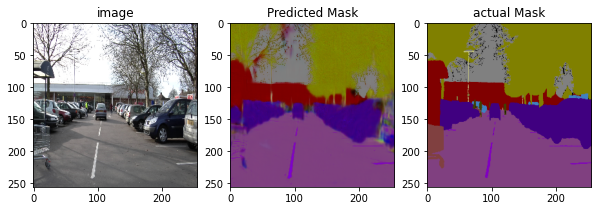

In [ ]:
test_predict, test_img, test_mask = prediction(np.array(test_image_names)[100:], np.array(test_mask_names)[100:], transformer_model)
for i in range(5):
  plot_result(test_img[i], test_predict[i], test_mask[i])
